# Análisis bursátil

# Temas a tratar

- Redes recurrentes.
- Uso de YahooFinance.
- Análisis de series temporales.
- Transformación de datos.
- Preprocesamiento para series temporales.
- LSTMs.


# Problema

Bitcoin, la criptomoneda más conocida y de mayor capitalización de mercado, ha experimentado una volatilidad significativa en su precio a lo largo de los años. Esta volatilidad hace que sea difícil de predecir con precisión el precio futuro de Bitcoin, lo que presenta un desafío para los inversores y comerciantes que buscan aprovechar las oportunidades en este mercado.

# Solución

Crear un modelo de IA que logre predecir las fluctuaciones de precio a lo largo del tiempo.

# Objetivo

El objetivo de este proyecto es desarrollar un modelo de aprendizaje profundo basado en una red neuronal recurrente de tipo LSTM (Long Short-Term Memory) que pueda analizar eficazmente los patrones históricos del precio de Bitcoin y realizar predicciones más precisas sobre su comportamiento futuro.

# Desarrollo

## Análisis y preprocesamiento de datos

### Análisis de datos

Para este caso usaremos datos reales extraídos de [YahooFinance](https://pypi.org/project/yfinance/), la forma más sencilla de obtener los valores de las acciones más relevantes de la actualidad financiera.

Para este caso descargamos el precio de bitcoin desde el 1ro de enero de 2015 hasta el primero de enero de 2024

In [2]:
import pandas as pd
import yfinance as yf

from_date = '2015-01-01'
to_date = '2024-01-01'

df = yf.download('BTC-USD', start=from_date, end=to_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


Como vemos tenemos varias columnas, `Open` con el precio de apertura, `High` con el máximo del día, `Low`, con el mínimo del día, `Close` con el precio de cierre, `Adj Close` que para el caso de bitcoin sería el mismo que `Close` porque no da dividendos, ni amortiza deuda, `Volume` la cantidad del activo en dólares que se movilizó.

Vamos a ver las estadística del conjunto

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3.287000e+03
mean,15030.227822,15381.631744,14651.962175,15041.625620,15041.625620,1.708190e+10
std,16240.295312,16630.177156,15803.040490,16242.203249,16242.203249,1.915408e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,7.860650e+06
25%,1185.275024,1206.515015,1172.234985,1187.840027,1187.840027,3.349970e+08
50%,8658.991211,8826.943359,8389.889648,8659.487305,8659.487305,1.278036e+10
75%,25141.166016,25937.496094,24849.660156,25369.524414,25369.524414,2.741688e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


Como vemos, el volumen va de los 7 millones a los 3 billones (trillones en inglés) de dólares lo que demuestra su interés creciente en los últimos años. A su vez se ve que el precio mínimo ha sido 178 USD y el máximo 67566 USD. Esto es relevante porque puede hacer que nuestra red no converja y tengamos que hacer algo para manerjarlo.

Vamos a considerar al precio del cierre nuestras features, y el precio de cierre al día actual como el target, pues nos ayuda a determinar si comprar o vender en el día, de acuerdo a lo que pasó en los días anteriores. Vamos a graficarlo.

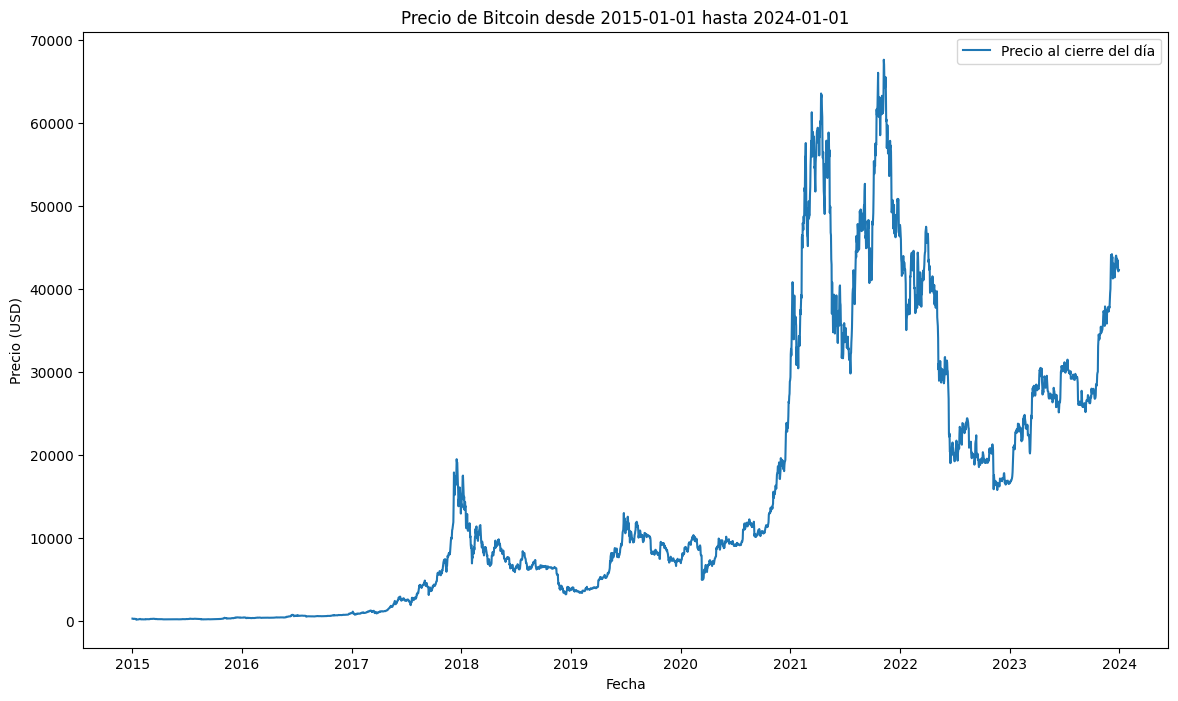

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='Precio al cierre del día')
plt.title(f'Precio de Bitcoin desde {from_date} hasta {to_date}')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

Un gráfico genial, que demustra una ligera tendencia alcista y varias fluctuaciones con variaciones tacionales que parecen darse cada 2 años.

### Preprocesamiento de los datos

In [ ]:
# Obtenemos la serie de precios como una matriz numpy
data = df[['Close']].values

Como vimos en la etapa de análisis, los valores están muy dispersos y van de un mínimo a un máximo muy alejados. Para arreglar esto se suelen hacer transformaciones como la normalización y la estandarización.

Para simplificar el proceso, solo vamos a reescalar todos los valores para que se encuentren entre 0 y 1 con `MinMaxScaler`

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Escalamos para que todos los valores esten entre 0 y 1 y hace más estable el entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Listo, al escalar, nuestro entrenamiento será más estable y evitaremos la saturación de nuestras funciones de activación.

Ahora vamos a dividir el dataset en conjunto de entranimiento y prueba. Como es una serie de tiempo podemos entrenar la red con los primeros elementos del conjunto y luego probar con los posteriores.

No obstante, recuerda que las LSTM necesitan una secuencia de entrada por lo que para probar un conjunto, necesitamos tomar prestados una serie de elementos del conjunto de entrenamiento que llamamos `look_back` que básicamente es la cantidad de elementos previos de la secuencia consideramos.

In [ ]:
# Dividimos el dataset

# Indicamos la longitud de nuestro dataset
training_data_len = int(len(scaled_data) * 0.8)

# Tomamos como conjunto de entrenamiento las primeras muestras
train_data = scaled_data[:training_data_len, :]

# Para predecir el precio actual tomaremos los 60 días anteriores
look_back = 60

# Tomamos las muestras de prueba. Tomamos `look_back` elementos antes del conjunto de pruebas
# para que el modelo logre predecir el elemento `0` del conjunto de pruebas
test_data = scaled_data[training_data_len - look_back:, :]

Genial, ya tenemos un conjunto de entrenamiento y pruebas, vamos a crear los splits para tener las features y los targets

In [ ]:
import numpy as np

def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Creamos los conjuntos
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Mostramos la forma de los array
print(X_train.shape, X_test.shape)

(2569, 60) (658, 60)


Excelente, tenemos el conjunto de entrenamiento con una forma `(2569, 60)` y pruebas `(658, 60)` para las features. El primer para `2569` nos indica la cantidad de muestras, mientras que el segundo par `60`, nos indica la cantidad de pasos en el tiempo que impactan a la decisión actual.

Para este caso solo escogimos una feature, pero el modelo no lo sabe, vamos a agregarle una dimensión al final para que el modelo sepa la cantidad de canales que pertenecen al conjunto.

In [ ]:
# Ajustamos la dimensión a [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Mostramos la forma de los array
print(X_train.shape, X_test.shape)

(2569, 60, 1)

Bien, ahora el primer par es la cantidad de muestras, el segundo la cantidad de días que se consideran para nuestro cálculo, y el tercer paso indica la cantidad de features del valor, en este caso `1` porque solo consideramos el valor de `Close` como entrada.

Ya está todo listo para jugar con la red

## Selección e implementación de modelo

Para este caso se escogió una LSTM, pero no se descarta que funcione con una recurrente normal o una GRU.

Vamos a crear una capa LSTM que sea seq2seq y que extraiga las features que le sirvan ya a otra LSTM seq2vec que termine de modelar la información para que una unidad neuronal sea capaz de predecir el precio de la acción.

In [ ]:
from tensorflow import keras

# Iniciamos el modelo
model = keras.models.Sequential()

# Agregamos una capa LSTM
model.add(keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)))

# Regularizamos para evitar overfitting a series de tiempo
model.add(keras.layers.Dropout(0.2))

# Agregamos una capa LSTM
model.add(keras.layers.LSTM(50, return_sequences=False))

# Regularizamos para evitar overfitting a series de tiempo
model.add(keras.layers.Dropout(0.2))

# Capa de salida con salida lineal
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')


Ya creamos nuestro modelo, vamos a correrlo por 100 épocas y veamos qué pasa

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
81/81 [==============================] - 8s 20ms/step - loss: 0.0076 - val_loss: 0.0012
Epoch 2/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 9.2204e-04
Epoch 3/100
81/81 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 9.4127e-04
Epoch 4/100
81/81 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 6.7630e-04
Epoch 5/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 7.3254e-04
Epoch 6/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 7.6460e-04
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 5.2984e-04
Epoch 8/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 7.2921e-04
Epoch 9/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 4.8499e-04
Epoch 10/100
81/81 [==============================] - 1s 10ms/step - 

La validación está baja porque los valores están entre 0 y 1, pero no hay que fiarse, vamos a revisar las predicciones

## Análisis de resultados

Hagamos las predicciones para analizarlas

In [ ]:
# Obtenemos las predicciones de pruebas y entrenamiento
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

21/21 [==============================] - 0s 4ms/step


Pero espera, estas predicciones están transformadas por el `scaler`, necesitamos reescalarlas.

In [ ]:
# Reescalamos para obtener los valores en la magnitud original
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

Perfecto, ahora vamos a poner las predicciones contra el valor actual en un gráfico para revisar fielmente la diferencia entre los valores predecidos y los esperados

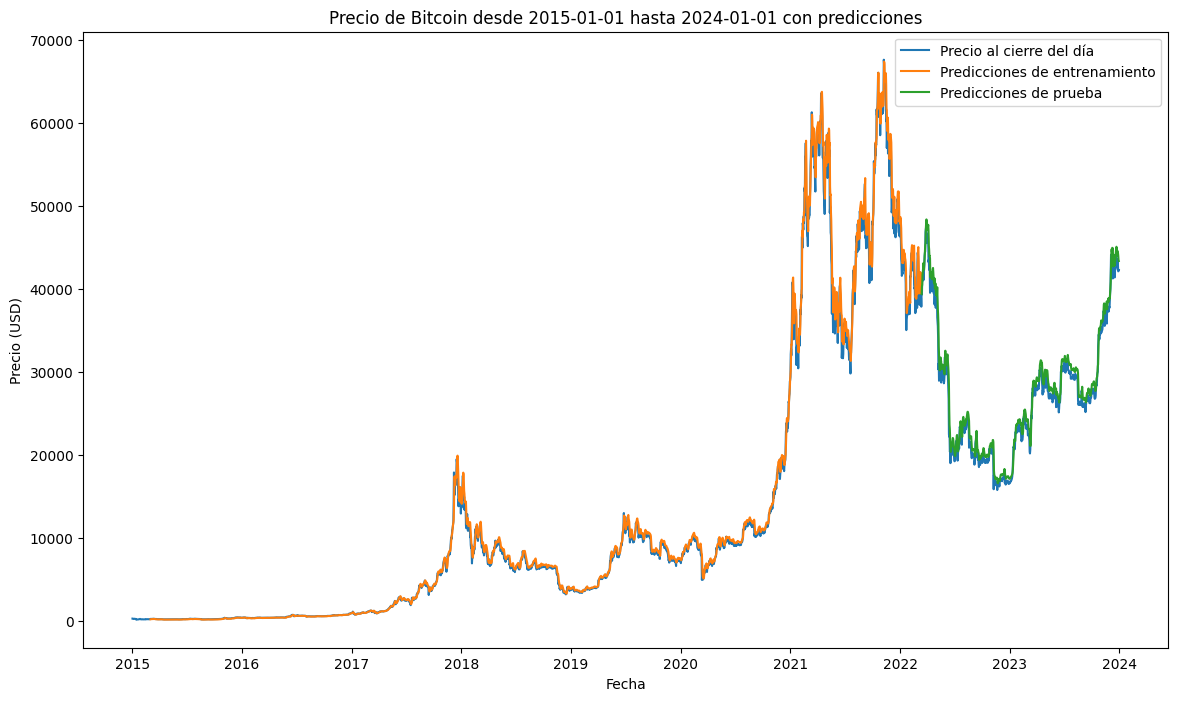

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='Precio al cierre del día')
plt.plot(df.index[look_back:training_data_len], train_predictions, label='Predicciones de entrenamiento')
plt.plot(df.index[training_data_len:], test_predictions, label='Predicciones de prueba')

plt.title(f'Precio de Bitcoin desde {from_date} hasta {to_date} con predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()


Como vemos, en azul (casi imperceptible) se ve los valores que se esperaban, en naranja las predicciones de entrenamiento, y en verde las predicciones de prueba. Parece que el modelo es bastante bueno prediciendo el precio de cierre basado en los 60 días anteriores.

## Despliegue

Obviamente predecir en datos pasados es aburrido, ¿cómo podríamos usar este modelo para predecir el precio a final de mes?, por ejemplo.

Vamos a tomar los valores de febero a mayo de 2024.

In [ ]:
data_today = yf.download('BTC-USD', start='2024-02-01', end='2024-05-18')
data_today = data_today[['Close']].values
data_today_scaled = scaler.transform(data_today)

[*********************100%%**********************]  1 of 1 completed


Ya los tomamos y escalamos, creemos una función para calcular el precio dada una secuencia

In [ ]:
def predict_next_price(model, data, sequence_length, transform = True):
    # Tomamos los últimos `sequence_length` elementos
    last_sequence = data[-sequence_length:]
    # Convertimos a dimensiones aceptables para el modelo
    last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))
    # Predecimos el precio
    next_price = model.predict(last_sequence)
    if transform:
      # Si queremos obtener el precio en USD transformamos
      next_price = scaler.inverse_transform(next_price)
    return next_price[0, 0]

Probemos que funcione

In [ ]:
predict_next_price(model, data_today_scaled, 60)

1/1 [==============================] - 0s 21ms/step


67014.37

Bitcoin va a valer ~67014 USD al terminar el 19 de mayo, y considerando que el precio anterior estaba en ~66923 parecía una opción para comprar. No obstante hubo una caída de casi 500USD de valoración (casi -1%) en ese día, por lo que hubiésemos perdido mucha plata si realizamos pérdidas.

Vale, para un día no es raro que pueda haber errores, pero qué hay de a largo plazo. ¿Cuánto valdrá bitcoin a mediados de junio según nuestro modelo?

In [ ]:
import numpy as np
data_today_scaled_copy = data_today_scaled.copy()
for i in range(30):
  next_price = predict_next_price(model, data_today_scaled_copy, 60, transform=False)
  data_today_scaled_copy = np.append(data_today_scaled_copy, next_price)

print(predict_next_price(model, data_today_scaled_copy, 60))

1/1 [==============================] - 0s 21ms/step
72629.74


72629 USD, claramente nuestro modelo es demasiado optimista, pero quién sabe, a lo mejor tiene razón.

# Conclusiones

Las LSTM son muy fuertes para ajustarse a series de tiempo y secuencias de datos, pero su fiabilidad es bastante cuestionable.

Es posible que para estos casos modelos comunes de investigación de operaciones y programación lineal sean más fiables para datos de los que se sepa fielmente las features.

Los modelos por su parte, son capaces de extraer features por su cuenta, así que pueden ser buenos modelos para crear hipótesis y descubrir factores que afectan el comportamiento de una secuencia.

# Tu turno

Nosotros usamos la LSTM para predecir el precio en un mes, pero no tenemos forma de saberlo hasta que llegue. ¿Qué tal probar con los valores pasados y ver si de verdad este modelo es de fiar?

Por otro lado usamos una LSTM, pero ¿por qué no pruebas usar una GRU?, en teoría a estas no les importa tanto el pasado como las LSTM por lo que para rangos cortos de tiempo parece ideal.